# Section 3 - Identifying features that may drive outcomes

* Building models that can predict outcomes from a set of features is one of the most common applications of statistics in the sciences
* This statistical method is broadly referred to as **regression**
* Typically, a scientist selects a set of features that they think influence their outcome and builds a (linear, logistic, *etc.*) model based on these features
* Least Absolute Shrinkage and Selection Operator (**LASSO**, also termed **L1 regularization**) is one regression method that helps identify features that drive outcomes
    * In simple terms, LASSO builds a model using all features as independent variables
    * Some coefficients for features are allowed to pass to zero if they do not strongly influence the results
    * LASSO thus provides **feature selection** by determining which features are most important to predicting the outcome
* As we will see, the features that do not drop out of the analysis may be helpful in generating hypotheses 

## Example 3.1
**Application 3.1**: Determining which features predict whether or not a segment of amino acids will be involved in an entanglement

* For this application we will use a dataset of 810 features computed for proteins in yeast
* Each protein was broken up into 9 amino acid segments using a sliding window (*e.g.*, residues [1-9] form segment 1, residues [2-10] form segment 2, *etc.*)
* This is a binary classification problem - we want to predict which segments will be entangled (outcome = 1) and which will not be entangled (outcome = 0)
* As we are trying to predict a binary outcome, we will apply LASSO to **logistic regression**
* Let's get started on our analysis in Python

### Step 0 - Load libraries

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

### Step 1 - Load the data & explore

In [2]:
# load data set as a pandas DataFrame object
data_path = "/home/jovyan/data-store/data/iplant/home/shared/NCEMS/BPS-training-2025/"
data6     = pd.read_csv(data_path+"yeast-processed_v2.csv")

print ("Create a quick summary of the DataFrame:\n")
data6.info()

print ("\nVisualize the first ten rows of the DataFrame:\n")
display(data6.head())

Create a quick summary of the DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Columns: 811 entries, A_-4_pssm to target_value
dtypes: float64(810), int64(1)
memory usage: 92.8 MB

Visualize the first ten rows of the DataFrame:



,A_-4_pssm,R_-4_pssm,N_-4_pssm,D_-4_pssm,C_-4_pssm,Q_-4_pssm,E_-4_pssm,G_-4_pssm,H_-4_pssm,I_-4_pssm,...,KARS160118_aaindex,KARS160119_aaindex,KARS160120_aaindex,KARS160121_aaindex,KARS160122_aaindex,str__AlphaHelix,str__Coil,str__Strand,str__Turn,target_value
0,-1.166467,3.063321,-0.464957,-0.637332,-1.258442,0.177605,-0.130065,-0.530745,-0.375076,-0.947012,...,-0.183969,-0.513191,0.575881,-0.238002,-1.247483,-1.808274,-0.035613,2.162757,-0.245399,1
1,-0.315714,-0.407209,0.251464,2.509363,0.807513,0.177605,1.967388,0.106022,-0.375076,0.003443,...,-0.346913,0.314936,0.479027,0.802531,-0.506544,0.553014,-0.035613,-0.462373,-0.245399,1
2,-1.166467,-1.448368,-1.539589,-1.581340,-0.432060,-1.375564,-1.528368,-1.485896,-1.501882,1.904353,...,0.328332,1.503480,0.441555,1.767465,0.037106,0.553014,-0.035613,-0.462373,-0.245399,0
3,0.960415,0.633950,1.326096,0.306677,-0.018869,0.954189,0.569086,2.016322,0.000526,-0.630194,...,0.681985,0.552420,0.716875,0.090801,0.035261,0.553014,-0.035613,-0.462373,-0.245399,0
4,-0.741091,-0.407209,-0.464957,-0.637332,-0.432060,-0.598979,-0.479641,-0.530745,1.127332,-0.313376,...,0.371299,-1.482826,0.962661,-1.057253,-1.117966,0.553014,-0.035613,-0.462373,-0.245399,0


* We have 811 columns corresponding to the 810 feature columns and the single outcome column
* In this instance, the outcome we are trying to predict is named `target_value`
* We will now check to see if the feature space has been scaled correctly

In [3]:
print ("\nInformation about mean and standard deviation of parameters:")
data6.describe()


Information about mean and standard deviation of parameters:


,A_-4_pssm,R_-4_pssm,N_-4_pssm,D_-4_pssm,C_-4_pssm,Q_-4_pssm,E_-4_pssm,G_-4_pssm,H_-4_pssm,I_-4_pssm,...,KARS160118_aaindex,KARS160119_aaindex,KARS160120_aaindex,KARS160121_aaindex,KARS160122_aaindex,str__AlphaHelix,str__Coil,str__Strand,str__Turn,target_value
count,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,...,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000
mean,9.947598e-18,3.457975e-17,1.444770e-17,-4.263256e-17,1.728987e-17,-1.894781e-18,-4.547474e-17,-1.705303e-17,-3.505344e-17,-1.326346e-17,...,-1.894781e-18,-2.664535e-17,2.178998e-17,1.657933e-18,-2.036889e-17,-1.117921e-16,3.907985e-17,1.148711e-16,1.411612e-16,0.500000
std,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,...,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,0.500017
min,-3.718725e+00,-2.836580e+00,-3.330643e+00,-2.840018e+00,-2.911205e+00,-2.928732e+00,-2.926670e+00,-2.441046e+00,-2.628689e+00,-2.531105e+00,...,-4.262544e+00,-4.514611e+00,-5.694541e+00,-4.451064e+00,-2.835015e+00,-1.808274e+00,-3.561282e-02,-4.623728e-01,-2.453987e-01,0.000000
25%,-7.410907e-01,-7.542619e-01,-8.231681e-01,-6.373316e-01,-4.320599e-01,-5.989794e-01,-8.292166e-01,-5.307452e-01,-7.506783e-01,-6.301941e-01,...,-6.377679e-01,-6.089267e-01,-5.958938e-01,-6.142900e-01,-7.175470e-01,5.530135e-01,-3.561282e-02,-4.623728e-01,-2.453987e-01,0.000000
50%,-3.157144e-01,-4.072089e-01,-1.067468e-01,-3.226621e-01,-1.886905e-02,-2.106873e-01,-1.300654e-01,-2.123618e-01,5.258429e-04,-3.133757e-01,...,4.078276e-02,9.482615e-02,1.684588e-01,9.080126e-02,-8.773702e-02,5.530135e-01,-3.561282e-02,-4.623728e-01,-2.453987e-01,0.500000
75%,5.350384e-01,2.868972e-01,6.096745e-01,6.213463e-01,3.943218e-01,5.658969e-01,5.690857e-01,4.244051e-01,3.761279e-01,6.370796e-01,...,6.489334e-01,7.449061e-01,7.464071e-01,7.231234e-01,6.367197e-01,5.530135e-01,-3.561282e-02,-4.623728e-01,-2.453987e-01,1.000000
max,3.512673e+00,3.757428e+00,3.833570e+00,3.453372e+00,6.178994e+00,4.060526e+00,3.365690e+00,3.289856e+00,4.883353e+00,3.171627e+00,...,4.139189e+00,2.378900e+00,1.468525e+00,3.428023e+00,5.120849e+00,5.530135e-01,2.807977e+01,2.162757e+00,4.075001e+00,1.000000


* Critically, we can see that the feature space has already been scaled such that each feature has a **mean of zero** and a **standard deviation of one**
* We need to check one final thing about our data set - whether or not the outcome classes are balanced

In [4]:
# calculate counts per outcome class
class_counts = data6["target_value"].value_counts()
print (class_counts)

target_value
1    7500
0    7500
Name: count, dtype: int64


* The outcome classes are perfectly balanced with 7,500 occurrances of both `0` and `1` - we are ready to proceed

### Step 2 - Prepare data for model building

* We need to split our complete dataset of 15,000 entries into three portions:
    * 1 - a dataset used to **train** the model *during* parameter tuning
    * 2 - a dataset used to **test** the model *during* parameter tuning
    * 3 - a **holdout** dataset used to **test** performance *after* parameter tuning
* We will first reserve a holdout dataset for final testing and use the rest for model training and parameter tuning
* In this example, we will use **k-fold cross validation** paired with a grid search to select the value of *λ*, the **hyperparameter** that determines the strength of regularization (how aggressively coefficients are collapsed to zero) in LASSO, while training and testing the model simultaneously
* In `sklearn`, regularization strength is controlled by the hyperparameter C = 1/*λ*

### K-Fold Cross Validation

* In **k-fold cross validation**, the set of non-holdout data is split into various different train-test subsets (**Figure 3.1.1**)

![](../images/K-fold_cross_validation_EN.png)

**Figure 3.1.1**. *In k-fold cross validation, every data point will be used to both train & test the model. Modified from https://en.wikipedia.org/wiki/Cross-validation_(statistics)*

* The cell below sets up the data splitting - we will reserve 20% of the data for final testing and use the other 80% for model training

In [5]:
# set a random seed to get deterministic behavior
random_seed = 1

# number of folds for cross-validation
Nfolds      = 5

# define feature and outcome datasets
X           = data6.drop(columns=["target_value"])
y           = data6["target_value"]

# reserve 20% of data for final testing after hyperparameter tuning
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

# set up k-fold cross-validation with outcome stratification
kf = StratifiedKFold(n_splits=Nfolds, shuffle=True, random_state=random_seed)

# set up set of lambda values for hyperparameter tuning
lambda_vals = np.logspace(-1, 4, 6)

### Step 3 - Optimize *λ*
* We are ready to run cross-validation and select the value of *λ*

In [6]:
# save the start time of the cell
startTime    = datetime.now()

# maximum number of iterations to be run
max_iter     = 10000

# setup dictionary to store results for each value of lambda
results_dict = {}

# loop over lambda values
for lambda_val in lambda_vals:

    # setup logistic regression model
    model                    = LogisticRegression(penalty="l1", solver="saga", 
                                                  max_iter=max_iter, C=1/lambda_val)

    # run cross-validation for current lambda_val
    cv_results               = cross_validate(model, X_train, y_train, cv=kf, return_estimator=True, 
                                              scoring=['balanced_accuracy', 'roc_auc'], n_jobs=-1)

    # store results for later
    results_dict[lambda_val] = cv_results

    # calculation elapsed time and print it to the screen
    elapsed_sec              = (datetime.now() - startTime).total_seconds()
    print(f"{lambda_val:10.4f} {elapsed_sec:10.2f} s")

    0.1000      67.10 s
    1.0000     124.93 s
   10.0000     175.24 s
  100.0000     204.51 s
 1000.0000     225.21 s
10000.0000     226.17 s


* Now that we have run cross-validation for each value of *λ*, let's assess the results
* We will use two performance metrics:
    * **Balanced accuracy**
        * Balanced accuracy = 1 indicates perfect predictions
        * Balanced accuracy = 0.5 indicates random classification
        * Balanced accuracy < 0.5 indicates *worse* than random classification 
    * Area Under the Receiver Operating Characteristic Curve (**AUROC**)
        * AUROC = 1 indicates perfect classification
        * AUROC = 0.5 indicates random classification
        * AUROC < 0.5 indicates worse than random classification

Lambda      Balanced Acc (mean ± std)  AUROC (mean ± std)            Non-zero Coeffs (mean ± std)
    0.1000	0.748 ± 0.008		0.826 ± 0.012		     507.8 ±       81.8
    1.0000	0.748 ± 0.008		0.827 ± 0.011		     283.0 ±       20.8
   10.0000	0.751 ± 0.005		0.830 ± 0.011		     187.4 ±        5.6
  100.0000	0.751 ± 0.008		0.829 ± 0.011		      46.6 ±        3.5
 1000.0000	0.738 ± 0.008		0.810 ± 0.011		       4.0 ±        0.0
10000.0000	0.500 ± 0.000		0.500 ± 0.000		       0.0 ±        0.0


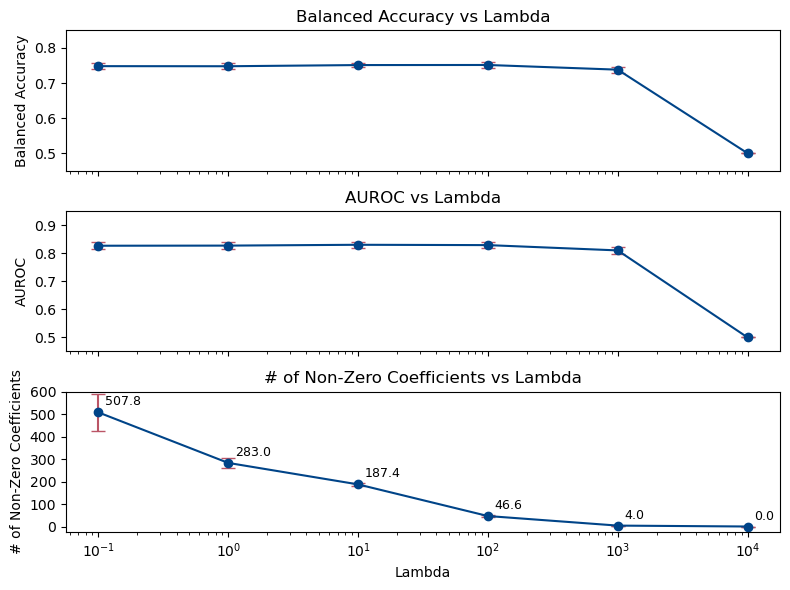

In [7]:
# sort the lambda values
lambda_vals                 = sorted(results_dict.keys())

# initialize lists to store the aggregated metric means and standard deviations
bal_acc_means, bal_acc_stds = [],[]
auroc_means, auroc_stds     = [],[]
nonzero_means, nonzero_stds = [],[]

# loop over each lambda and compute metrics
for lambda_val in lambda_vals:
    
    cv_results     = results_dict[lambda_val]
    
    # extract balanced accuracy and AUROC scores
    test_bal_acc   = cv_results['test_balanced_accuracy']
    test_roc_auc   = cv_results['test_roc_auc']
    
    # compute mean and standard deviation
    mean_bal_acc   = np.mean(test_bal_acc)
    std_bal_acc    = np.std(test_bal_acc, ddof=1)
    mean_roc_auc   = np.mean(test_roc_auc)
    std_roc_auc    = np.std(test_roc_auc, ddof=1)
    
    # compute number of non-zero coefficients for each fold
    nonzero_counts = [np.count_nonzero(estimator.coef_[0]) for estimator in cv_results['estimator']]
    mean_nonzero   = np.mean(nonzero_counts)
    std_nonzero    = np.std(nonzero_counts, ddof=1)
    
    # Append the computed metrics to the corresponding lists
    bal_acc_means.append(mean_bal_acc)
    bal_acc_stds.append(std_bal_acc)
    auroc_means.append(mean_roc_auc)
    auroc_stds.append(std_roc_auc)
    nonzero_means.append(mean_nonzero)
    nonzero_stds.append(std_nonzero)

# print summary information to screen
header = ("Lambda".ljust(12) + "Balanced Acc (mean ± std)".ljust(27) +
          "AUROC (mean ± std)".ljust(30) + "Non-zero Coeffs (mean ± std)")
print(header)

for i, lambda_val in enumerate(lambda_vals):
    nonzero_str = f"{nonzero_means[i]:10.1f} ± {nonzero_stds[i]:10.1f}"
    print(f"{lambda_val:10.4f}\t" f"{bal_acc_means[i]:0.3f} ± {bal_acc_stds[i]:0.3f}\t\t"
          f"{auroc_means[i]:0.3f} ± {auroc_stds[i]:0.3f}\t\t" f"{nonzero_str}")

# create summary plots
plot_color  = "#004488"
error_color = "#BB5566"
fig, axes   = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# plot Balanced Accuracy
axes[0].errorbar(lambda_vals, bal_acc_means, yerr=bal_acc_stds, fmt='o-', capsize=5, color=plot_color, ecolor=error_color)
axes[0].set_xscale('log')
axes[0].set_ylabel('Balanced Accuracy')
axes[0].set_title('Balanced Accuracy vs Lambda')
axes[0].set_ylim(0.45, 0.85)
axes[0].set_yticks([0.5, 0.6, 0.7, 0.8])

# plot AUROC
axes[1].errorbar(lambda_vals, auroc_means, yerr=auroc_stds, fmt='o-', capsize=5, color=plot_color, ecolor=error_color)
axes[1].set_xscale('log')
axes[1].set_ylabel('AUROC')
axes[1].set_title('AUROC vs Lambda')
axes[1].set_ylim(0.45, 0.95)
axes[1].set_yticks([0.5, 0.6, 0.7, 0.8, 0.9])

# plot number of non-zero coefficients
axes[2].errorbar(lambda_vals, nonzero_means, yerr=nonzero_stds, fmt='o-', capsize=5,color=plot_color, ecolor=error_color)
axes[2].set_xscale('log')
axes[2].set_ylabel('# of Non-Zero Coefficients')
axes[2].set_title('# of Non-Zero Coefficients vs Lambda')
axes[2].set_ylim(-25, 600)
axes[2].set_yticks([0, 100, 200, 300, 400, 500, 600])
axes[2].set_xlabel('Lambda')

# annotate each point with the mean number of non-zero coefficients (to one decimal)
for i, lambda_val in enumerate(lambda_vals):
    axes[2].annotate(f"{nonzero_means[i]:.1f}", (lambda_val, nonzero_means[i]), 
                     textcoords="offset points", xytext=(5, 5), fontsize=9, color='black')

plt.tight_layout()
plt.show()

* With LASSO, we get to choose our preferred trade off between number of non-zero features and performance.
* In this case, we can achieve strong performance with *λ* = 1,000 and have only 4 features to consider

### Step 4 - Build & test the final model
* We can now construct the final model by training on all data except the holdout dataset with *λ* = 1000.
* After training the final model, we will test its performance on the unseen holdout set

In [8]:
# choose our preferred value of lambda
final_lambda        = 1000.

# setup the model
final_model         = LogisticRegression(penalty="l1", solver="saga", max_iter=max_iter, C=1/final_lambda)

# fit the model to the data
final_model.fit(X_train, y_train)

# evaluate the final model on the holdout dataset
y_holdout_pred_prob = final_model.predict_proba(X_holdout)[:, 1]
y_holdout_pred      = final_model.predict(X_holdout)
holdout_auroc       = roc_auc_score(y_holdout, y_holdout_pred_prob)
holdout_bal_acc     = balanced_accuracy_score(y_holdout, y_holdout_pred)

print ("Performance on holdout data\n")
print("Holdout AUROC             :", '%.3f' %holdout_auroc)
print("Holdout Balanced Accuracy :", '%.3f' %holdout_bal_acc)

# extract the nonzero coefficients
coef                = final_model.coef_.flatten()
nonzero_indices     = coef != 0
nonzero_coefs       = coef[nonzero_indices]
nonzero_features    = X_train.columns[nonzero_indices]

# sort coefficients by magnitude in descending order
sorted_indices      = abs(nonzero_coefs).argsort()[::-1]
sorted_features     = nonzero_features[sorted_indices]
sorted_coefs        = nonzero_coefs[sorted_indices]

# print nonzero coefficients
print("\nNonzero Coefficients (sorted by magnitude)\n")
for feature, value in zip(sorted_features, sorted_coefs):
    print(feature.ljust(26) + ": " + "%.5f" % value)

Performance on holdout data

Holdout AUROC             : 0.813
Holdout Balanced Accuracy : 0.739

Nonzero Coefficients (sorted by magnitude)

CN_exp                    : 0.46217
Theta_exp                 : 0.20938
SS7__Strand               : 0.12323
rsaa                      : -0.08388
Tau_exp                   : -0.01460


### Step 5 - Assess the results
* We observe that there are five rather than four non-zero features - we expect some differences between this final model, parameterized based on the entire training set, and those trained during cross-validation
* These non-zero features can serve as the basis for hypothesis generation; for example:
    *  Why is `CN_exp`, which represents the local packing density of a set of residues, important to our ability to predict the outcome?